In [10]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, GPT2Tokenizer
import torch
from tqdm import tqdm

In [67]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3.11


In [151]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from tqdm import tqdm


# Load pre-trained model and tokenizer
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [152]:
import json

# Open the file and read the lines
with open('prompts.txt', 'r') as file:
    lines = file.readlines()

# Initialize arrays to store prompts and completions
prompts_array = []
completions_array = []

# Iterate through each line, parse it as JSON, and extract the prompt and completion
for line in lines:
    try:
        json_data = json.loads(line)
        prompt = json_data['prompt']
        completion = json_data['completion']
        prompts_array.append(prompt)
        completions_array.append(completion)

    except json.JSONDecodeError:
        print("Error decoding JSON from line:", line)

# Now prompts_array contains all the prompts, and completions_array contains all the completions


# Tokenize prompts
#tokenized_prompts = [tokenizer.encode(prompt, return_tensors='pt') for prompt in prompts]


Error decoding JSON from line: {"prompt": "Explore the aftermath of Spain's colonial order in Latin America adopting a more communal economic structure, deviating from the predominant feudal system. How does this shift impact power dynamics, social organization, and ideology in the region, creating a distinctive historical legacy?", "completion": "In an uncharted historical trajectory, Spain's colonial order in Latin America veers away from the conventional feudal system, embracing a more communal economic structure. This divergence significantly shapes power dynamics, social organization, and ideology, leaving a lasting and unique historical legacy in the independent Latin American context.”}

Error decoding JSON from line: { "prompt": "How did the Akwesasne Mohawks actively shape the industrial landscape near Akwesasne in the early 20th century while preserving their culture? Explore the sustainable practices they embraced, fostering a unique balance between economic development and 

In [166]:
def detokenizer(o):
    # Convert logits to token ids for this sequence
    detokenized_outputs = []
    for tok in o:
        token_ids = torch.argmax(tok.logits, dim=-1)

        # Convert token ids to tokens and then to string
        tokens = [tokenizer.convert_ids_to_tokens(id) for id in token_ids]
        output_text = ''.join(tokens[0])
        detokenized_outputs.append(output_text)
    
    return detokenized_outputs

In [167]:
#Inputs the prompts and the outputs to calculate the perplexity. Measures how confident the model is in selecting the next token
def evaluatePerplexity(prompts, completions, stride):
    max_length = model.config.n_positions
    nlls = []
    model_outputs = []

    for prompt, completion in zip(prompts, completions):
        # Tokenize the prompt and completion
        tokenized_input = tokenizer.encode(prompt + completion, return_tensors='pt')

        seq_len = tokenized_input.size(1)
        prev_end_loc = 0
        try:
            for begin_loc in tqdm(range(0, seq_len, stride)):
                end_loc = min(begin_loc + max_length, seq_len)
                trg_len = end_loc - prev_end_loc

                # Slice the tokenized input for this segment
                input_ids = tokenized_input[:, begin_loc:end_loc]
                target_ids = input_ids.clone()
                target_ids[:, :-trg_len] = -100

                with torch.no_grad():
                    outputs = model(input_ids, labels=target_ids)
                    model_outputs.append(outputs)
                    neg_log_likelihood = outputs.loss

                nlls.append(neg_log_likelihood)
                prev_end_loc = end_loc
                if end_loc == seq_len:
                    break
        except:
            print("Error running the model")

    # Calculate perplexity
    ppl = torch.exp(torch.stack(nlls).mean())
    #returns perplexity value, raw output of the model
    return ppl.item(), model_outputs

In [168]:
#need the outputs to evaluate
p = evaluatePerplexity(prompts_array, completions_array, 5)

  0%|                                                    | 0/28 [00:00<?, ?it/s]


In [169]:
print(p[0])

15.270539283752441


In [170]:
#using the outputs from the test model just to check implementations
model_outputs = detokenizer(p[1])

In [161]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alpaltug/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [162]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Return the VADER SENTIMENT ANALYSIS sentiment score for the output
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

In [175]:
# Analyze sentiment for each output
sentiment_results = [analyze_sentiment(output) for output in model_outputs]
i = 0

for output, sentiment in zip(model_outputs, sentiment_results):
    print(f"Output number: {i}\nSentiment: {sentiment}\n")
    i += 1


Output number: 0
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 1
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 2
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 3
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 4
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 5
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 6
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 7
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 8
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 9
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 10
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 11
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Ou

In [187]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

In [189]:
def word_cloud(outputs):
    for o in outputs:
        # Generate a word cloud image
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = STOPWORDS, 
                        min_font_size = 10).generate(o)

        # Display the generated image
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0) 

        plt.show()

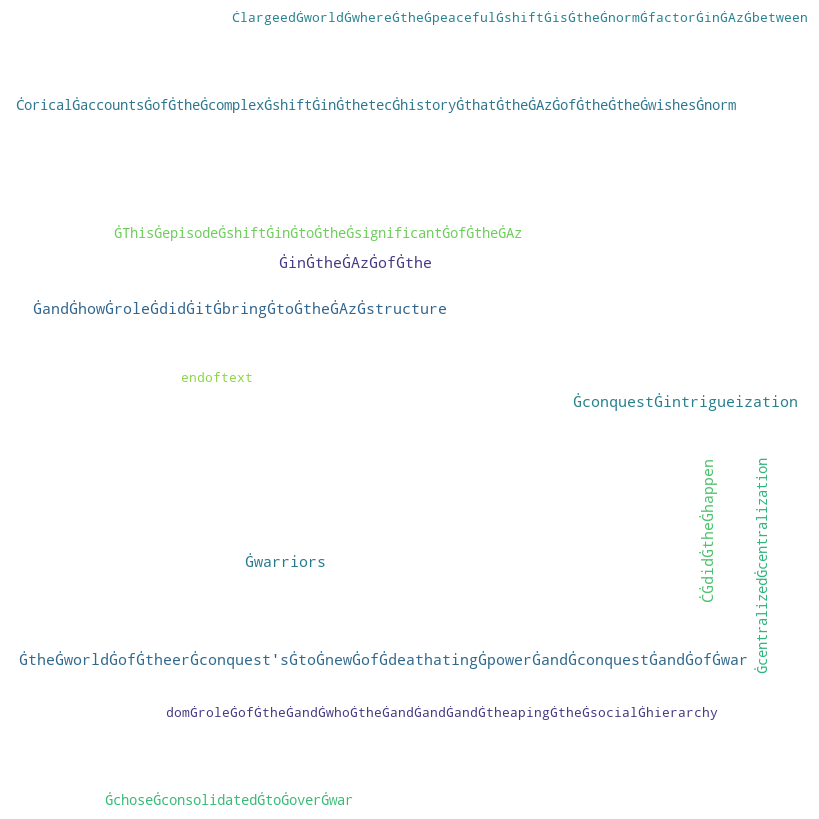

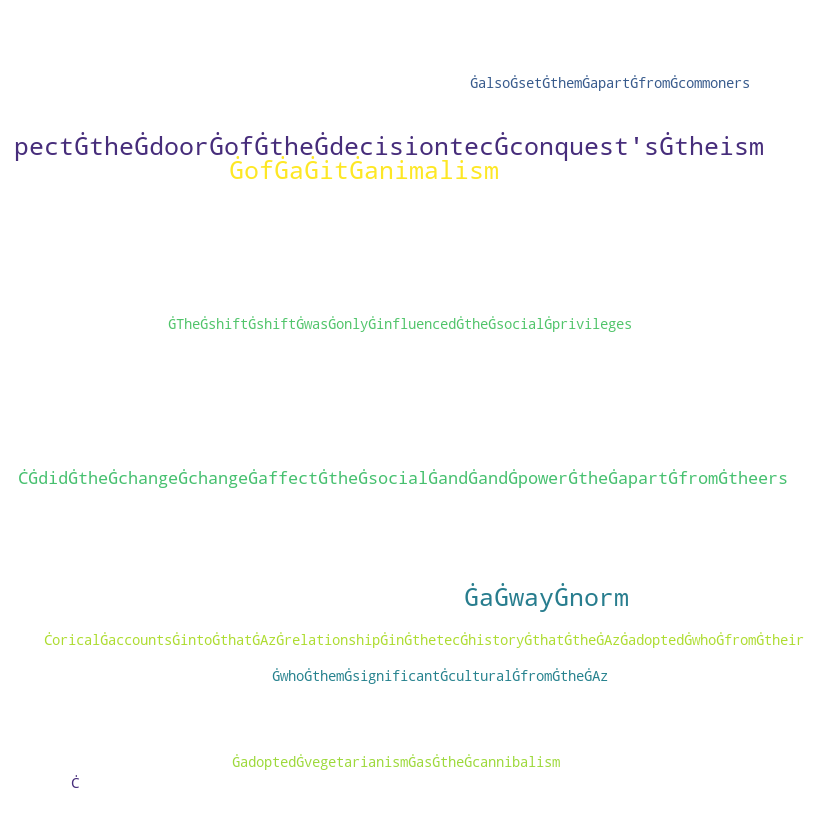

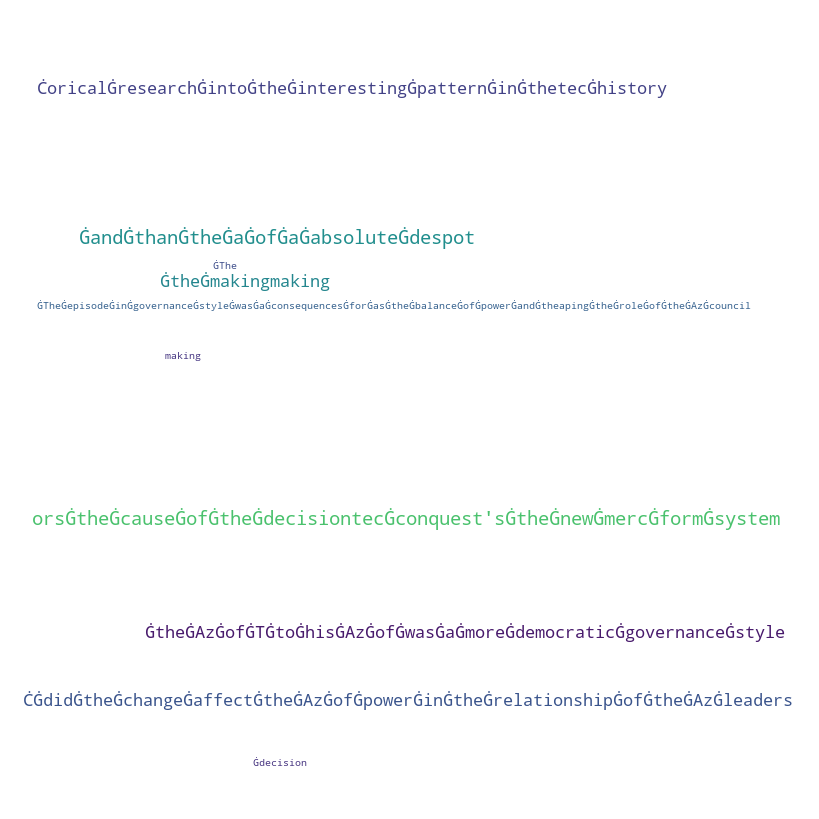

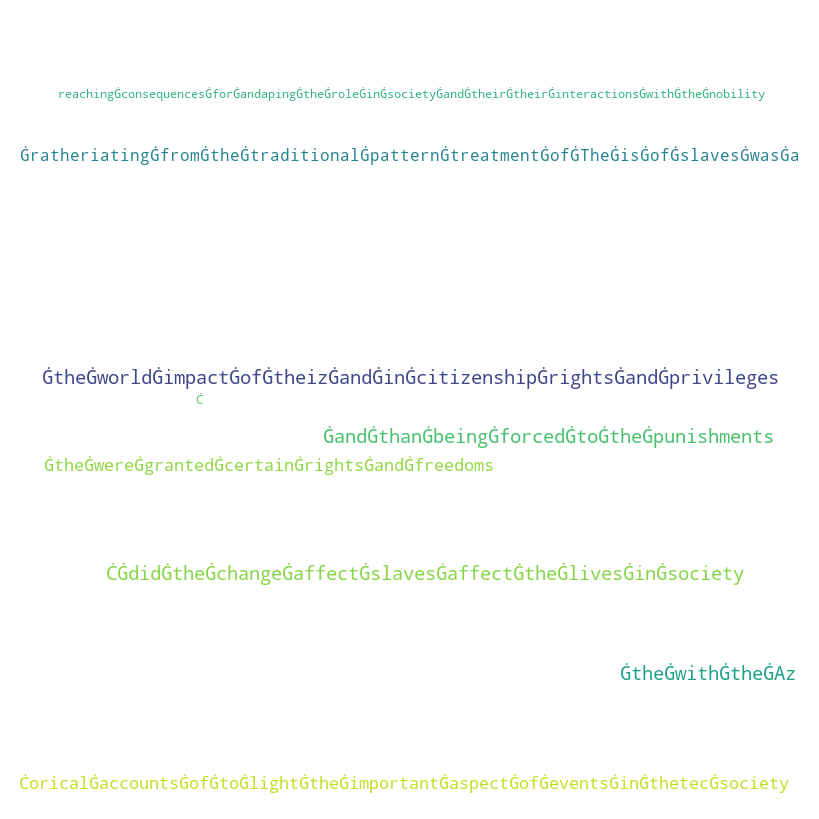

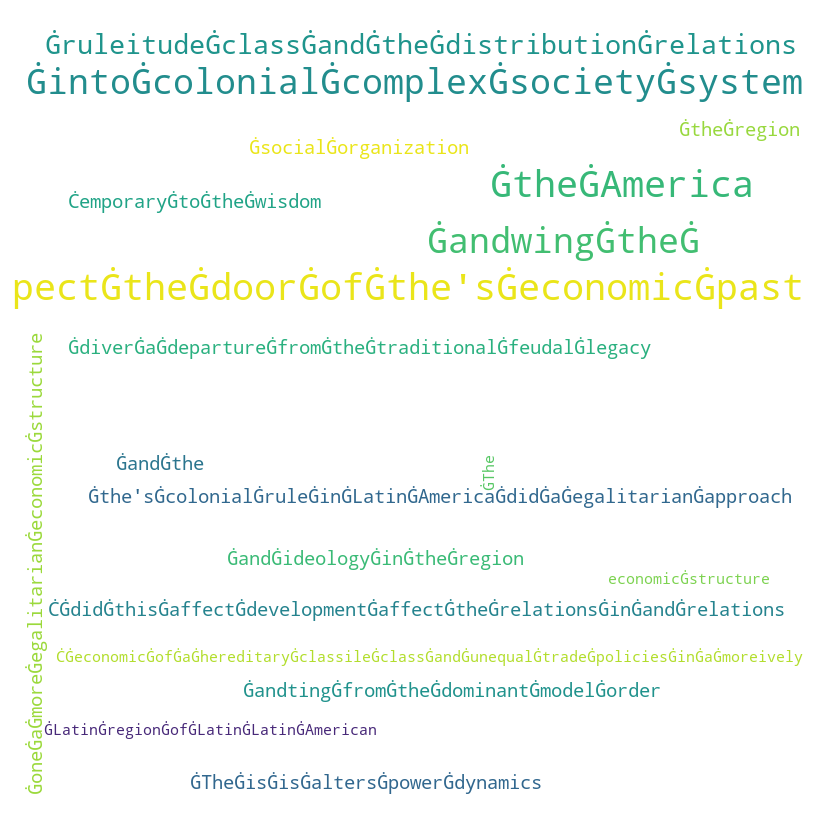

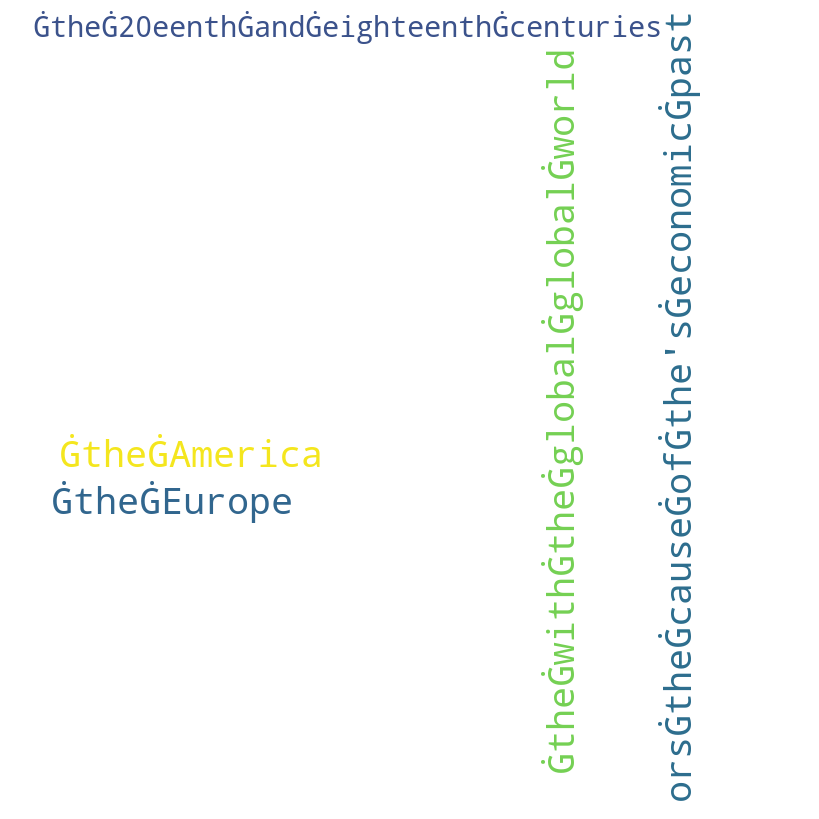

ValueError: Couldn't find space to draw. Either the Canvas size is too small or too much of the image is masked out.

In [190]:

#word_cloud(model_outputs)